In [11]:
import os

from glob import glob
import cv2
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append("/kaggle/src/")

from model.model_module import ModelModule
from conf import ExpConfig
from score.rle_convert import rle_encode, rle_decode
from score.compute_score import compute_surface_dice_score, add_size_columns

In [12]:
config = ExpConfig()
model = ModelModule(config)
# modelの読み込み
# model_path = "/kaggle/working/exp001_making3/last.pth"
model_path = "/kaggle/working/exp001_validscore/last.pth"
# model.load_state_dict(torch.load(model_path))
model.to("cuda")

ModelModule(
  (model): SimpleSegModel(
    (encoder): SimpleTimmEncoder(
      (encoder): FeatureListNet(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU(inplace=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (drop_block): Identity()
            (act2): ReLU(inplace=True)
       

In [13]:
data_name = "kidney_1_dense"
slice_id = "0500"
data_id = data_name + "_" + slice_id

image = cv2.imread(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/{slice_id}.tif", cv2.IMREAD_GRAYSCALE)
pred, pred_counts = model.overlap_predict(image)

In [14]:
rle = rle_encode((pred > 0.5).astype(np.uint8))
print(rle)

2 1 21 1 31 1 37 1 99 2 115 1 129 2 136 2 140 1 166 1 223 2 271 1 274 1 305 1 315 2 346 1 372 1 399 1 411 1 450 1 460 1 486 1 490 1 506 1 558 1 588 2 601 1 608 1 623 2 633 1 651 1 736 1 746 2 757 1 761 1 766 1 791 1 799 1 837 1 853 1 861 1 875 1 891 1 895 1 908 1 914 1 936 1 938 2 942 2 946 1 956 1 973 1 989 2 994 1 998 1 1002 1 1004 1 1011 2 1016 1 1022 3 1027 1 1035 1 1042 1 1044 2 1048 1 1052 1 1055 1 1063 1 1066 1 1071 1 1075 1 1084 3 1088 1 1107 2 1110 1 1115 2 1118 1 1129 1 1136 2 1146 1 1149 2 1153 1 1160 2 1166 1 1179 1 1181 1 1186 1 1189 1 1192 1 1197 1 1205 1 1216 1 1238 1 1242 1 1256 3 1270 2 1276 2 1284 1 1289 2 1305 2 1317 1 1323 1 1335 1 1347 1 1357 1 1360 2 1370 3 1378 1 1381 1 1387 1 1402 1 1416 2 1424 2 1437 1 1457 1 1495 3 1506 2 1527 1 1539 1 1546 1 1555 1 1564 1 1585 1 1590 1 1611 1 1620 1 1625 1 1630 1 1648 2 1662 2 1672 2 1685 1 1695 1 1707 1 1713 1 1741 2 1748 3 1770 2 1773 1 1787 1 1799 1 1802 3 1813 2 1819 4 1826 1 1832 1 1843 4 1848 1 1851 2 1854 1 1857 3 1863

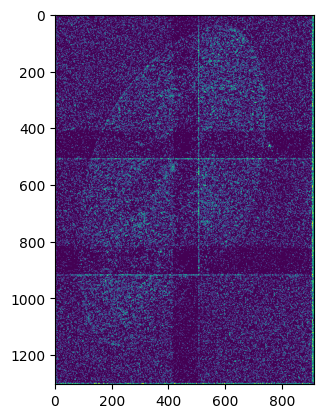

In [15]:
decoded_pred = rle_decode(rle, (pred.shape[0], pred.shape[1]))
plt.imshow(decoded_pred)

In [16]:
# data_name = "kidney_1_dense"
# data_name = "kidney_2"
# data_id_list = []
# rle_list = []
# data_num = len(glob(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/*.tif"))

# for slice_id in tqdm(range(500, 600)):
#     data_id = f"{data_name}_{slice_id:04d}"
#     image = cv2.imread(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/{slice_id:04d}.tif", cv2.IMREAD_GRAYSCALE)
#     pred, pred_counts = model.overlap_predict(image)
#     rle = rle_encode((pred > 0.5).astype(np.uint8))
#     rle_list.append(rle)
#     data_id_list.append(data_id)

# submit = pd.DataFrame({
#     "id": data_id_list,
#     "rle": rle_list
# })

In [17]:
data_dir = config.input_data_dir
train_data_dir = os.path.join(data_dir, "train")
# print(train_data_dir)
# data_name_list = os.listdir(train_data_dir)
data_name_list = ["kidney_2"]
# print(data_name_list)

config.overlap_rate = 0.2
config.threshold = 0.5

submit = model.inference(train_data_dir, data_name_list)


 predicting... => kidney_2, slice num: 2217
0200/2217, 4.51 [min]Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_522858/2905147190.py", line 11, in <module>
    submit = model.inference(train_data_dir, data_name_list)
  File "/kaggle/src/model/model_module.py", line 84, in inference
    val_score = compute_surface_dice_score(submit, label)
  File "/kaggle/src/valid.py", line 48, in make_submit_df
    pred, _ = model.overlap_predict(image)
  File "/kaggle/src/processing/postprocess.py", line -1, in remove_small_objects
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1428, i

In [ ]:
# submit = pd.read_csv("/kaggle/input/submission_sample.csv")
# submit


,id,rle
0,kidney_1_dense_0000,1 0
1,kidney_1_dense_0001,1 0
2,kidney_1_dense_0002,1 0
3,kidney_1_dense_0003,1 0
4,kidney_1_dense_0004,1 0
...,...,...
2274,kidney_1_dense_2274,711994 2 712906 2 713817 2 714729 2 715640 2 7...
2275,kidney_1_dense_2275,1 0
2276,kidney_1_dense_2276,1 0
2277,kidney_1_dense_2277,1 0


In [ ]:
data_id_list = submit["id"].values.tolist()

label = pd.read_csv("/kaggle/input/blood-vessel-segmentation/train_rles.csv")
label = label[label["id"].isin(data_id_list)].reset_index(drop=True)
add_size_columns(label)
# label

In [ ]:
%%time
# Compute surface Dice score
score = compute_surface_dice_score(submit, label)
score

CPU times: user 4.51 s, sys: 14.3 ms, total: 4.53 s
Wall time: 4.53 s


0.87990802526474


overlap=0.2, threshold=0.5 0.402873158454895


overlap=0.5, threshold=0.5 0.3703303039073944

overlap=0.5, threshold=0.1 0.3497748374938965